In [1]:
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Visualizing
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

import acquire_PJ


# Sklearn Cluster and Scaler 
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Tests RFE, REGRESSION MODEL
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
import sklearn.preprocessing


# Other Models
from sklearn.linear_model import LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr


# rmse to check baseline and model
from sklearn.metrics import mean_squared_error

In [2]:
zillow_df = acquire_PJ.get_zillow_data()
zillow_df.head()

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [3]:
# Create a function that will remove rows and columns that have missing values past a certain threshold.
def handle_missing_values(df, p_row = 0.84, p_col = 0.84):
    ''' function which takes in a dataframe, required notnull proportions of non-null rows and columns.
    drop the columns and rows columns based on theshold:'''
    
    #drop columns with nulls
    threshold = int(p_col * len(df.index)) # Require that many non-NA values.
    df.dropna(axis = 1, thresh = threshold, inplace = True)
    
    #drop rows with nulls
    threshold = int(p_row * len(df.columns)) # Require that many non-NA values.
    df.dropna(axis = 0, thresh = threshold, inplace = True)
    
    
    return df

In [4]:
zillow_df = handle_missing_values(zillow_df)

In [5]:
# Create a list of columns to drop.
columns_to_drop = ['transactiondate','assessmentyear','id','Unnamed: 0','parcelid','calculatedbathnbr'
                   ,'finishedsquarefeet12','fullbathcnt','propertycountylandusecode','propertylandusetypeid',
                   'rawcensustractandblock','regionidcity','regionidcounty','regionidzip',
                   'structuretaxvaluedollarcnt','censustractandblock','propertylandusedesc', 'roomcnt']



In [6]:
def drop_columns(df, drop_col):
    df = df.drop(columns=drop_col)
    return df

In [7]:
zillow_df = drop_columns(zillow_df, columns_to_drop)

In [8]:
for col in zillow_df.columns:
    if zillow_df[col].isna().sum() > 0:
        zillow_df[col] = zillow_df[col].fillna(value = zillow_df[col].mean())
        #print(zillow_df[col])

In [9]:
zillow_df = zillow_df.rename(columns = {'fips':'county', 'calculatedfinishedsquarefeet' : 'area', 'bathroomcnt' : 'bathrooms',
                         'bedroomcnt' : 'bedrooms', 'poolcnt' : 'pools', 'garagecarcnt' : 'garages',
                          'taxvaluedollarcnt': 'tax_value'})

In [10]:
# Cleaning the data
# Creating counties
zillow_df['LA_County']= zillow_df['county'] == 6037
zillow_df['Orange_County']= zillow_df['county'] == 6059
zillow_df['Ventura_County']= zillow_df['county'] == 6111


zillow_df['LA_County'] = zillow_df['LA_County'].replace(False, 0)
zillow_df['LA_County'] = zillow_df['LA_County'].replace(True, 1)

zillow_df['Orange_County'] = zillow_df['Orange_County'].replace(False, 0)
zillow_df['Orange_County'] = zillow_df['Orange_County'].replace(True, 1)

zillow_df['Ventura_County'] = zillow_df['Ventura_County'].replace(False, 0)
zillow_df['Ventura_County'] = zillow_df['Ventura_County'].replace(True, 1)

In [11]:
def yearbuilt_years(df):
    df.yearbuilt =  df.yearbuilt.astype(int)
    year = date.today().year
    df['age'] = year - df.yearbuilt
    # dropping the 'yearbuilt' column now that i have the age
    df = df.drop(columns=['yearbuilt'])
    return df

In [12]:
zillow_df = yearbuilt_years(zillow_df)

In [13]:
zillow_df = zillow_df[zillow_df.bedrooms != 0]
zillow_df = zillow_df[zillow_df.bathrooms != 0]

In [14]:
# Later Lets look at pools and garages!
# Create new features here

zillow_df['acres']= zillow_df.lotsizesquarefeet/43560


# ratio of bathrooms to bedrooms
zillow_df['bed_bath_ratio'] = zillow_df.bedrooms / zillow_df.bathrooms

# bin ages
#zillow_df['age_bins'] = pd.cut(zillow_df.age, 
#                               bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
#                               labels = [0, .066, .133, .20, .266, .333, .40, .466, .533, 
#                                     .60, .666, .733, .8, .866, .933])

# bin from brent
zillow_df['age_bins'] = pd.cut(zillow_df.age, 2, labels=[0, 1])


# bin acres
zillow_df['acres_bin'] = pd.cut(zillow_df.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 50, 200], 
                    labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])
    

#zillow_df['logerror_bins'] = pd.cut(zillow_df.logerror, bins = [-5, -3, -2, -1, -.05, 0, .05, 1, 2, 3, 4],
#                                      labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])    


zillow_df['land_dollar_per_sqft'] = zillow_df.landtaxvaluedollarcnt/zillow_df.lotsizesquarefeet

zillow_df['lot_dollar_sqft_bin'] = pd.cut(zillow_df.land_dollar_per_sqft, bins = [0, 1, 5, 20, 50, 100, 250, 500, 1000, 1500, 2000],
                                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                      )


# update datatypes of binned values to be float
#zillow_df = zillow_df.astype({'acres_bin': 'float64', 'age_bin': 'float64'}).dtypes
zillow_df = zillow_df.astype({'acres_bin': float, 'age_bins': float, 'lot_dollar_sqft_bin' : float}) #'logerror_bins' : float

In [218]:
zillow_df.logerror

1        0.055619
2        0.005383
3       -0.103410
5       -0.020526
7        0.101723
           ...   
77564    0.319408
77567    0.081196
77568    0.001082
77571    0.013209
77573    0.007204
Name: logerror, Length: 45647, dtype: float64

In [15]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''

    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [16]:
col_list = ['bedrooms', 'bathrooms', 'area', 'tax_value',
            'lotsizesquarefeet', 'taxamount', 'age', 'acres',
           'bed_bath_ratio', 'landtaxvaluedollarcnt']
k = 1.5
    
zillow_df = remove_outliers(zillow_df, k, col_list)

In [17]:
# Splitting my data
def split(df, target_var):
    
    # split df into train_validate (80%) and test (20%)
    train_validate, test = train_test_split(df, test_size=.20, random_state=13)
    
    # split train_validate into train(70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=13)

    # create X_train by dropping the target variable 
    X_train = train.drop(columns=[target_var])
    # create y_train by keeping only the target variable.
    y_train = train[[target_var]]

    # create X_validate by dropping the target variable 
    X_validate = validate.drop(columns=[target_var])
    # create y_validate by keeping only the target variable.
    y_validate = validate[[target_var]]

    # create X_test by dropping the target variable 
    X_test = test.drop(columns=[target_var])
    # create y_test by keeping only the target variable.
    y_test = test[[target_var]]

    partitions = [train, X_train, y_train, validate, X_validate, y_validate, test, X_test, y_test]
    return partitions

In [18]:
partitions = split(zillow_df, target_var = 'logerror')

In [198]:
len(partitions)

9

## Stats Tests

In [19]:
train = partitions[0]

In [20]:
# Acres_bin hold a significance with logerror

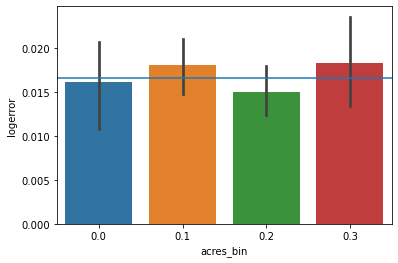

In [21]:
sns.barplot(x = 'acres_bin', y = 'logerror', data = train)
population_logerror_mean = train.logerror.mean()
plt.axhline(population_logerror_mean)
plt.show()

In [45]:
train.head()

,bathrooms,bedrooms,area,county,latitude,longitude,lotsizesquarefeet,tax_value,landtaxvaluedollarcnt,taxamount,logerror,LA_County,Orange_County,Ventura_County,age,acres,bed_bath_ratio,age_bins,acres_bin
62952,2.0,3.0,1910.0,6037.0,34141135.0,-118069733.0,14690.0,84943.0,34939.0,1358.67,-0.023357,1,0,0,87,0.337236,1.500000,0.600,0.3
18519,3.0,5.0,2965.0,6037.0,34116699.0,-118226054.0,5562.0,439333.0,292893.0,5438.55,0.114887,1,0,0,41,0.127686,1.666667,0.333,0.1
31433,3.0,3.0,2388.0,6037.0,33875945.0,-118355497.0,17419.0,350032.0,109462.0,4386.48,0.139967,1,0,0,33,0.399885,1.000000,0.266,0.3
2249,2.0,3.0,1353.0,6059.0,33858501.0,-117963533.0,6700.0,129412.0,71148.0,1748.20,-0.002537,0,1,0,67,0.153811,1.500000,0.466,0.2
24002,1.5,2.0,1024.0,6059.0,33842442.0,-117944157.0,1048.0,201596.0,146657.0,2601.14,-0.066029,0,1,0,58,0.024059,1.333333,0.400,0.0


In [ ]:
# unclear using pearsons r to see signifcance

In [22]:
test_results = stats.pearsonr(train.logerror, train.acres_bin)
r, p = test_results
print("r: ", r, "p: ", p)

r:  -0.0013498620109291 p:  0.829141396438407


In [23]:
test_results = stats.pearsonr(train.logerror, train.area)
r, p = test_results
print("r: ", r, "p: ", p)

r:  0.01708583143516444 p:  0.006300548418552481


# tax value hold a significance with logerror

<Figure size 1152x576 with 0 Axes>

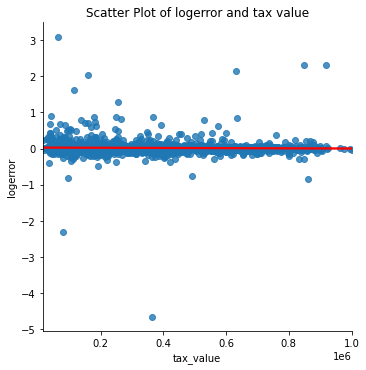

In [24]:
#sns.scatterplot(x= train.tax_value, y= train.logerror)
# population_logerror_mean = train.logerror.mean()
#plt.axhline(population_logerror_mean)
#plt.show()


plt.figure(figsize=(16,8))
sns.lmplot(data = train.sample(2000), x = 'tax_value', y = 'logerror',line_kws={'color': 'red'})
plt.title("Scatter Plot of logerror and tax value")
plt.show()

In [25]:
test_results = stats.pearsonr(train.logerror, train.tax_value)
r, p = test_results
print("r: ", r, "p: ", p)

r:  -0.03305615952081189 p:  1.2492339028107507e-07


# bed_bath_ratio affect logerror?

<Figure size 1152x576 with 0 Axes>

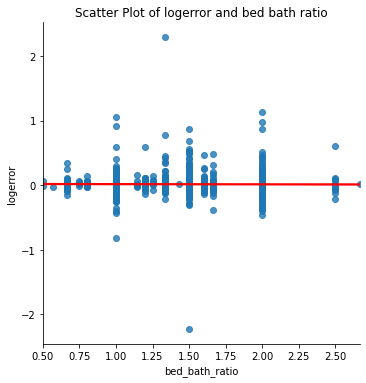

In [26]:
plt.figure(figsize=(16,8))
sns.lmplot(data = train.sample(2000), x = 'bed_bath_ratio', y = 'logerror',line_kws={'color': 'red'})
plt.title("Scatter Plot of logerror and bed bath ratio")
plt.show()

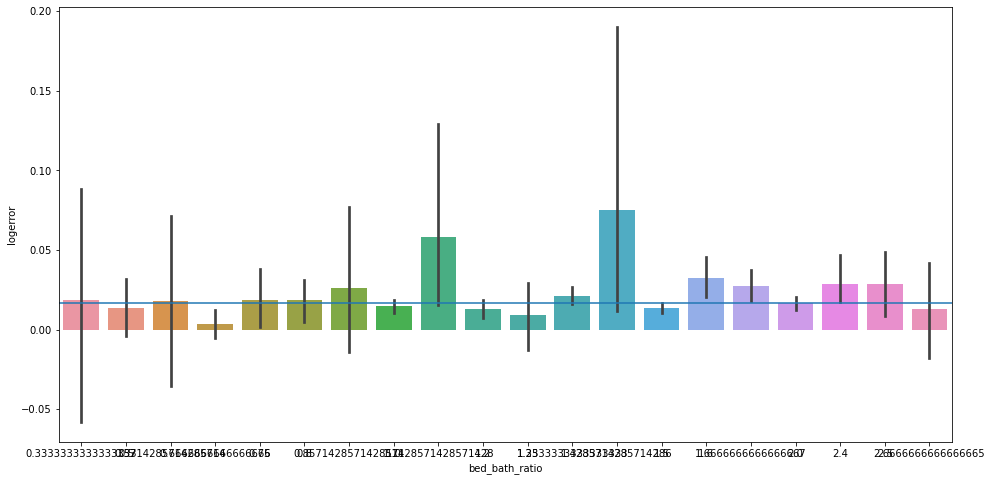

In [27]:

plt.figure(figsize=(16,8))
sns.barplot(x = 'bed_bath_ratio', y = 'logerror', data = train)
population_logerror_mean = train.logerror.mean()
plt.axhline(population_logerror_mean)
plt.show()

In [28]:
test_results = stats.pearsonr(train.logerror, train.bed_bath_ratio)
r, p = test_results
print("r: ", r, "p: ", p)

r:  0.008497328842119659 p:  0.17430676524774985


# lot_dollar_sqft affect logerror

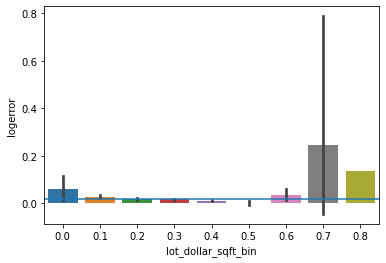

In [29]:
sns.barplot(x = 'lot_dollar_sqft_bin', y = 'logerror', data = train)
population_logerror_mean = train.logerror.mean()
plt.axhline(population_logerror_mean)
plt.show()

In [30]:
test_results = stats.pearsonr(train.logerror, train.lot_dollar_sqft_bin)
r, p = test_results
print("r: ", r, "p: ", p)

r:  -0.03610964475341162 p:  7.707134037995697e-09


# Age bins created by brent have a significance

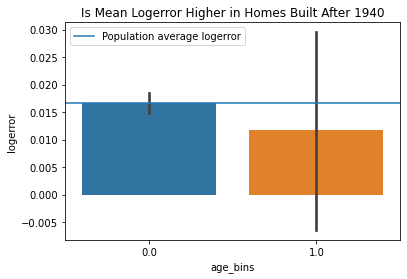

In [31]:
plt.title("Is Mean Logerror Higher in Homes Built After 1940")
sns.barplot(x="age_bins", y="logerror", data=train)
population_logerror_mean = train.logerror.mean()
plt.axhline(population_logerror_mean, label="Population average logerror")
plt.legend()
plt.show()

In [34]:
older_homes_logerror = train[train.age_bins == 0].logerror
newer_homes_logerror = train[train.age_bins == 1].logerror

In [35]:
# Check for equal variances.
# A stats Levene test - returns p value. small p-value means unequal variances.
t, p = stats.levene(older_homes_logerror, newer_homes_logerror)
# high p-value suggests that the populations have equal variances.

if p < alpha:
    print(f'p-value: {p}. There is unequal variance.')

p-value: 4.0886780156041265e-16. There is unequal variance.


In [33]:
alpha = 0.01
sample = train[train.age_bins == 0].logerror
overall_mean = train.logerror.mean()

t, p = stats.ttest_1samp(sample, overall_mean)

print(t, p/2, alpha)

0.10998872086139677 0.45620960105827857 0.01


In [36]:
# Run a Independent T-Test to test for a difference in mean logerror between newer homes and older homes.
t, p = stats.ttest_ind(older_homes_logerror, newer_homes_logerror, equal_var=False)
if p < alpha:
    print(f'p-value: {p}. We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

We fail to reject the null hypothesis.


# Scaling Stuff

In [84]:
X_train = partitions[1]

# Dropping Unneeded features
#X_train = train.drop(columns = ['county', 'bathrooms', 'bedrooms', 'latitude', 'longitude',
#                               'lotsizesquarefeet', 'landtaxvaluedollarcnt', 'taxamount',
#                               'LA_County', 'Orange_County', 'Ventura_County', 'area',
#                                'age_bins', 'acres_bin', 'logerror'])
# changed area for bed_bath_ratio
X_train = train.drop(columns = ['logerror'])
# Set scaler
scaler = MinMaxScaler(copy=True)
x_train_scaled = scaler.fit_transform(X_train)

x_train_scaled = pd.DataFrame(x_train_scaled, columns = X_train.columns.to_list())

# Finding the best features to use

In [86]:
y_train = partitions[2]

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, 6)

# fit the data using RFE
rfe.fit(x_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = x_train_scaled.iloc[:,feature_mask].columns.tolist()

rfe_feature

['bedrooms',
 'latitude',
 'age',
 'age_bins',
 'land_dollar_per_sqft',
 'lot_dollar_sqft_bin']

In [151]:
X_train.head()

,bathrooms,bedrooms,area,county,latitude,longitude,lotsizesquarefeet,tax_value,landtaxvaluedollarcnt,taxamount,LA_County,Orange_County,Ventura_County,age,acres,bed_bath_ratio,age_bins,acres_bin
62952,2.0,3.0,1910.0,6037.0,34141135.0,-118069733.0,14690.0,84943.0,34939.0,1358.67,1,0,0,87,0.337236,1.500000,0.600,0.3
18519,3.0,5.0,2965.0,6037.0,34116699.0,-118226054.0,5562.0,439333.0,292893.0,5438.55,1,0,0,41,0.127686,1.666667,0.333,0.1
31433,3.0,3.0,2388.0,6037.0,33875945.0,-118355497.0,17419.0,350032.0,109462.0,4386.48,1,0,0,33,0.399885,1.000000,0.266,0.3
2249,2.0,3.0,1353.0,6059.0,33858501.0,-117963533.0,6700.0,129412.0,71148.0,1748.20,0,1,0,67,0.153811,1.500000,0.466,0.2
24002,1.5,2.0,1024.0,6059.0,33842442.0,-117944157.0,1048.0,201596.0,146657.0,2601.14,0,1,0,58,0.024059,1.333333,0.400,0.0


In [152]:
x_train_scaled.head()

,bathrooms,bedrooms,area,county,latitude,longitude,lotsizesquarefeet,tax_value,landtaxvaluedollarcnt,taxamount,LA_County,Orange_County,Ventura_County,age,acres,bed_bath_ratio,age_bins,acres_bin
0,0.333333,0.4,0.561482,0.000000,0.581106,0.732089,0.691286,0.076407,0.043242,0.118489,1.0,0.0,0.0,0.727273,0.691286,0.500000,0.727520,1.000000
1,0.666667,0.8,0.898435,0.000000,0.563372,0.650667,0.248630,0.434103,0.402679,0.479588,1.0,0.0,0.0,0.309091,0.248630,0.571429,0.363760,0.333333
2,0.666667,0.4,0.714149,0.000000,0.388642,0.583245,0.823626,0.343969,0.147083,0.386473,1.0,0.0,0.0,0.236364,0.823626,0.285714,0.272480,1.000000
3,0.333333,0.4,0.383584,0.297297,0.375982,0.787405,0.303816,0.121291,0.093696,0.152965,0.0,1.0,0.0,0.545455,0.303816,0.500000,0.544959,0.666667
4,0.166667,0.2,0.278505,0.297297,0.364327,0.797497,0.029727,0.194148,0.198911,0.228457,0.0,1.0,0.0,0.463636,0.029727,0.428571,0.455041,0.000000


In [153]:
rfe_scaled = x_train_scaled[rfe_feature]

# Creating base model

In [157]:
train = partitions[0]
train.head()

,bathrooms,bedrooms,area,county,latitude,longitude,lotsizesquarefeet,tax_value,landtaxvaluedollarcnt,taxamount,logerror,LA_County,Orange_County,Ventura_County,age,acres,bed_bath_ratio,age_bins,acres_bin
62952,2.0,3.0,1910.0,6037.0,34141135.0,-118069733.0,14690.0,84943.0,34939.0,1358.67,-0.023357,1,0,0,87,0.337236,1.500000,0.600,0.3
18519,3.0,5.0,2965.0,6037.0,34116699.0,-118226054.0,5562.0,439333.0,292893.0,5438.55,0.114887,1,0,0,41,0.127686,1.666667,0.333,0.1
31433,3.0,3.0,2388.0,6037.0,33875945.0,-118355497.0,17419.0,350032.0,109462.0,4386.48,0.139967,1,0,0,33,0.399885,1.000000,0.266,0.3
2249,2.0,3.0,1353.0,6059.0,33858501.0,-117963533.0,6700.0,129412.0,71148.0,1748.20,-0.002537,0,1,0,67,0.153811,1.500000,0.466,0.2
24002,1.5,2.0,1024.0,6059.0,33842442.0,-117944157.0,1048.0,201596.0,146657.0,2601.14,-0.066029,0,1,0,58,0.024059,1.333333,0.400,0.0


In [158]:
y_train = partitions[2]
# Setting y_train to a data frame


y_train = pd.DataFrame(y_train)

y_train['baseline_mean'] = y_train['logerror'].mean()
y_train['baseline_med'] = y_train['logerror'].median()


y_train.head()

,logerror,baseline_mean,baseline_med
62952,-0.023357,0.016591,0.006288
18519,0.114887,0.016591,0.006288
31433,0.139967,0.016591,0.006288
2249,-0.002537,0.016591,0.006288
24002,-0.066029,0.016591,0.006288


In [159]:
rmse_train = mean_squared_error(y_train.logerror, y_train.baseline_mean)**(1/2)
rmse_train2 = mean_squared_error(y_train.logerror, y_train.baseline_med)**(1/2)

print("RMSE using Mean \n Train / In-Sample", round(rmse_train, 5))
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train2, 3))

RMSE using Mean 
 Train / In-Sample 0.14874
RMSE using Median
Train/In-Sample:  0.149


# Using Models
## OLS MODEL 1 

In [160]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm.fit(rfe_scaled, y_train.logerror)

# predict train
y_train['tax_pred_lm'] = lm.predict(rfe_scaled)

# evaluate: rmse
rmse_train_ols = mean_squared_error(y_train.logerror, y_train.tax_pred_lm)**(1/2)


print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_ols)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.14853134400961857


## Laso

In [161]:
lars = LassoLars(alpha=1.0, random_state=123)

# fit the model to our training data. 
# since we have converted it to a dataframe from a series! 
lars.fit(rfe_scaled, y_train.logerror)

# predict train
y_train['tax_pred_lars'] = lars.predict(rfe_scaled)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.logerror, y_train.tax_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars) 

RMSE for Lasso + Lars
Training/In-Sample:  0.14873716094456157


# Polynomial

In [162]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(rfe_scaled)

In [164]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['tax_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_poly = mean_squared_error(y_train.logerror, y_train.tax_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_poly)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.14835078434057344


In [165]:
print("Baseline: ", rmse_train)

print("RMSE OLY: ", rmse_train_ols)
print("RMSE LASO: ", rmse_train_lars)
print("RMSE POLY: ", rmse_train_poly)

Baseline:  0.14873716094456157
RMSE OLY:  0.14853134400961857
RMSE LASO:  0.14873716094456157
RMSE POLY:  0.14835078434057344


### Takeways from first models w/o cluster features

- Since baseline is 0.16444 based off the features (age, tax_value, area, acres)
- We see after running through 3 models OLS, LASO R, and Polynomial models all barely beat the baseline

Baseline : 0.16444
---------------------------------
-- OLS  w/ : 0.16427466848815073

-- LASO w/ : 0.16443995174606943

-- Poly w/ : 0.16427466848815073

- OLS and Poly have a tie for beating BASELINE by about: 0.000165

# -----------------------------------------------
# -----------------------------------------------
# Clustering Again
# -----------------------------------------------
# -----------------------------------------------

In [42]:
x_train_scaled.head()

,area,tax_value,age,acres
0,0.685575,0.765358,0.866667,0.555636
1,0.454921,0.124550,0.590476,0.590344
2,0.464313,0.728086,0.466667,0.582263
3,0.519159,0.430171,0.514286,0.936593
4,0.455297,0.248032,0.647619,0.652196


### Create Our Clusters

In [166]:

k = 6

#cluster_vars = ['age_bins', 'tax_value', 'acres_bin']
cluster_vars = ['age', 'acres', 'bed_bath_ratio', 'tax_value']
# changed area to bed_bath_ratio
cluster_name = 'area_cluster'


# Let's move forward with k=5
kmeans = KMeans(n_clusters = 6, random_state=420)
#kmeans.fit(x_train_scaled)
kmeans.fit(rfe_scaled[rfe_feature])

# And assign the cluster number to a column on the dataframe
rfe_scaled["cluster"] = kmeans.predict(rfe_scaled[rfe_feature])
rfe_scaled.head()

,area,landtaxvaluedollarcnt,taxamount,age,cluster
0,0.561482,0.043242,0.118489,0.727273,2
1,0.898435,0.402679,0.479588,0.309091,3
2,0.714149,0.147083,0.386473,0.236364,1
3,0.383584,0.093696,0.152965,0.545455,0
4,0.278505,0.198911,0.228457,0.463636,0


## OLS MODEL WITH CLUSTER

In [170]:
# Running it with a model again?

# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm.fit(rfe_scaled, y_train.logerror)

# predict train
y_train['tax_pred_lm'] = lm.predict(rfe_scaled)

# evaluate: rmse
rmse_train_ols = mean_squared_error(y_train.logerror, y_train.tax_pred_lm)**(1/2)


print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_ols)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.1485265208938589


In [ ]:
RMSE OLY:  0.14853134400961857

## LARS MODEL WITH CLUSTER

In [171]:
lars = LassoLars(alpha=1.0, random_state=123)

# fit the model to our training data. 
# since we have converted it to a dataframe from a series! 
lars.fit(rfe_scaled, y_train.logerror)

# predict train
y_train['tax_pred_lars'] = lars.predict(rfe_scaled)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.logerror, y_train.tax_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars) 

RMSE for Lasso + Lars
Training/In-Sample:  0.14873716094456157


## POLY MODEL WITH CLUSTER

In [172]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(rfe_scaled)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['tax_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_poly = mean_squared_error(y_train.logerror, y_train.tax_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_poly)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.14834016273778589


### Takeaways w/ cluster feature
##### now i used rfe-features instead
- Since baseline is 0.14844 based off the features (age, tax_value, area, acres, cluster)
- We see after running through 3 models OLS, LASO R, and Polynomial models all barely beat the baseline

Baseline : 0.14844
---------------------------------
-- OLS  w/ : 0.1485265208938589

-- LASO w/ : 0.14873716094456157

-- Poly w/ : 0.14834016273778589

- Poly beating BASELINE by about: 0.0001

## Testing on validate

In [179]:

X_validate = partitions[4]

# Dropping Unneeded features
#X_train = train.drop(columns = ['county', 'bathrooms', 'bedrooms', 'latitude', 'longitude',
#                               'lotsizesquarefeet', 'landtaxvaluedollarcnt', 'taxamount',
#                               'LA_County', 'Orange_County', 'Ventura_County', 'area',
#                                'age_bins', 'acres_bin', 'logerror'])
# changed area for bed_bath_ratio
# X_validate = train.drop(columns = ['logerror'])
# Set scaler
scaler = MinMaxScaler(copy=True)
x_validate_scaled = scaler.fit_transform(X_validate)

x_validate_scaled = pd.DataFrame(x_validate_scaled, columns = X_validate.columns.to_list())

In [181]:
rfe_validate_scaled = x_validate_scaled[rfe_feature]

In [182]:
y_validate = partitions[5]
# Setting y_train to a data frame


y_validate = pd.DataFrame(y_validate)

y_validate['baseline_mean'] = y_validate['logerror'].mean()
y_validate['baseline_med'] = y_validate['logerror'].median()


y_validate.head()

,logerror,baseline_mean,baseline_med
25835,-0.015865,0.01716,0.006564
13856,0.032065,0.01716,0.006564
14254,-0.151605,0.01716,0.006564
28445,0.003786,0.01716,0.006564
1090,0.007799,0.01716,0.006564


In [183]:
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.baseline_mean)**(1/2)
rmse_validate2 = mean_squared_error(y_validate.logerror, y_validate.baseline_med)**(1/2)

print("RMSE using Mean \n Validate / In-Sample", round(rmse_validate, 5))
print("RMSE using Median\nValidate/In-Sample: ", round(rmse_validate2, 3))

RMSE using Mean 
 Validate / In-Sample 0.15778
RMSE using Median
Validate/In-Sample:  0.158


## Without Clusters Validate

### W/O Cluster OLS

In [185]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm.fit(rfe_validate_scaled, y_validate.logerror)

# predict train
y_validate['tax_pred_lm'] = lm.predict(rfe_validate_scaled)

# evaluate: rmse
rmse_train_ols = mean_squared_error(y_validate.logerror, y_validate.tax_pred_lm)**(1/2)


print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_ols)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.15767169963511846


### W/O CLuster LARS

In [186]:
lars = LassoLars(alpha=1.0, random_state=123)

# fit the model to our training data. 
# since we have converted it to a dataframe from a series! 
lars.fit(rfe_validate_scaled, y_validate.logerror)

# predict train
y_validate['tax_pred_lars'] = lars.predict(rfe_validate_scaled)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_validate.logerror, y_validate.tax_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars) 

RMSE for Lasso + Lars
Training/In-Sample:  0.1577791502206339


### W/O Clusters Poly

In [187]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_validate_degree2 = pf.fit_transform(rfe_validate_scaled)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm2.fit(X_validate_degree2, y_validate.logerror)

# predict train
y_validate['tax_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_train_poly = mean_squared_error(y_validate.logerror, y_validate.tax_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_poly)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.1575182941337037


## W/. Clusters Validate

#### Create Cluster Variable

In [188]:

k = 6

#cluster_vars = ['age_bins', 'tax_value', 'acres_bin']
cluster_vars = ['age', 'acres', 'bed_bath_ratio', 'tax_value']
# changed area to bed_bath_ratio
cluster_name = 'area_cluster'


# Let's move forward with k=5
kmeans = KMeans(n_clusters = 6, random_state=420)
#kmeans.fit(x_train_scaled)
kmeans.fit(rfe_validate_scaled[rfe_feature])

# And assign the cluster number to a column on the dataframe
rfe_validate_scaled["cluster"] = kmeans.predict(rfe_validate_scaled[rfe_feature])
rfe_validate_scaled.head()

,area,landtaxvaluedollarcnt,taxamount,age,cluster
0,0.488727,0.064692,0.338361,0.216216,0
1,0.668748,0.847347,0.894129,0.711712,2
2,0.318071,0.121039,0.231864,0.324324,0
3,0.196323,0.704315,0.527908,0.630631,5
4,0.805064,0.031949,0.118641,0.459459,3


### OLS w/ cluster

In [189]:
# Running it with a model again?

# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm.fit(rfe_validate_scaled, y_validate.logerror)

# predict train
y_validate['tax_pred_lm'] = lm.predict(rfe_validate_scaled)

# evaluate: rmse
rmse_train_ols = mean_squared_error(y_validate.logerror, y_validate.tax_pred_lm)**(1/2)


print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_ols)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.15767124803775276


In [190]:
lars = LassoLars(alpha=1.0, random_state=123)

# fit the model to our training data. 
# since we have converted it to a dataframe from a series! 
lars.fit(rfe_validate_scaled, y_validate.logerror)

# predict train
y_validate['tax_pred_lars'] = lars.predict(rfe_validate_scaled)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_validate.logerror, y_validate.tax_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars) 

RMSE for Lasso + Lars
Training/In-Sample:  0.1577791502206339


In [191]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_validate_degree2 = pf.fit_transform(rfe_validate_scaled)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm2.fit(X_validate_degree2, y_validate.logerror)

# predict train
y_validate['tax_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_train_poly = mean_squared_error(y_validate.logerror, y_validate.tax_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_poly)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.1575063766843707


## Takeaway Polynomial is the best model

In [192]:

X_test = partitions[7]

# Dropping Unneeded features
#X_train = train.drop(columns = ['county', 'bathrooms', 'bedrooms', 'latitude', 'longitude',
#                               'lotsizesquarefeet', 'landtaxvaluedollarcnt', 'taxamount',
#                               'LA_County', 'Orange_County', 'Ventura_County', 'area',
#                                'age_bins', 'acres_bin', 'logerror'])
# changed area for bed_bath_ratio
# X_validate = train.drop(columns = ['logerror'])
# Set scaler
scaler = MinMaxScaler(copy=True)
x_test_scaled = scaler.fit_transform(X_test)

x_test_scaled = pd.DataFrame(x_test_scaled, columns = X_test.columns.to_list())

In [193]:
rfe_test_scaled = x_test_scaled[rfe_feature]

In [194]:
y_test = partitions[8]
# Setting y_train to a data frame


y_test = pd.DataFrame(y_test)

y_test['baseline_mean'] = y_test['logerror'].mean()
y_test['baseline_med'] = y_test['logerror'].median()


y_test.head()

,logerror,baseline_mean,baseline_med
46865,0.235333,0.014448,0.005255
23424,0.472950,0.014448,0.005255
32862,0.020028,0.014448,0.005255
50972,-0.603977,0.014448,0.005255
54001,0.006727,0.014448,0.005255


In [195]:
rmse_test = mean_squared_error(y_test.logerror, y_test.baseline_mean)**(1/2)
rmse_test2 = mean_squared_error(y_test.logerror, y_test.baseline_med)**(1/2)

print("RMSE using Mean \n Validate / In-Sample", round(rmse_test, 5))
print("RMSE using Median\nValidate/In-Sample: ", round(rmse_test2, 3))

RMSE using Mean 
 Validate / In-Sample 0.17389
RMSE using Median
Validate/In-Sample:  0.174


In [196]:
k = 6

#cluster_vars = ['age_bins', 'tax_value', 'acres_bin']
cluster_vars = ['age', 'acres', 'bed_bath_ratio', 'tax_value']
# changed area to bed_bath_ratio
cluster_name = 'area_cluster'


# Let's move forward with k=5
kmeans = KMeans(n_clusters = 6, random_state=420)
#kmeans.fit(x_train_scaled)
kmeans.fit(rfe_test_scaled[rfe_feature])

# And assign the cluster number to a column on the dataframe
rfe_test_scaled["cluster"] = kmeans.predict(rfe_test_scaled[rfe_feature])
rfe_test_scaled.head()

,area,landtaxvaluedollarcnt,taxamount,age,cluster
0,0.319581,0.368123,0.358602,0.481818,0
1,0.172472,0.150249,0.228240,0.690909,2
2,0.269192,0.345173,0.367258,0.627273,0
3,0.924586,0.673053,0.760180,0.563636,3
4,0.474806,0.022500,0.099941,0.509091,2


In [197]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_test_degree2 = pf.fit_transform(rfe_test_scaled)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm2.fit(X_test_degree2, y_test.logerror)

# predict train
y_test['tax_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test_poly = mean_squared_error(y_test.logerror, y_test.tax_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_test_poly)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.17345462138997467


In [211]:
 ((0.17389 - 0.17345) / 0.17389)

0.0025303352694231755

In [ ]:
0.003